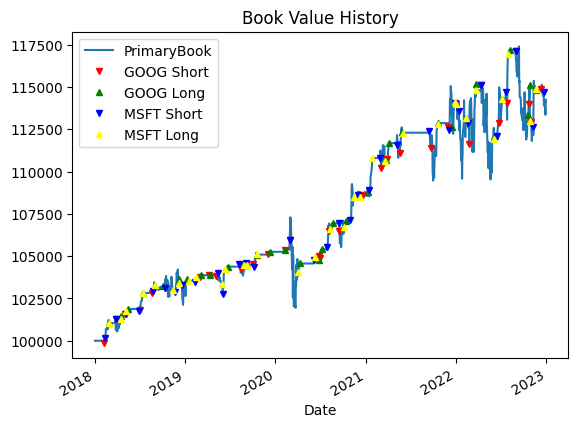

In [1]:
import inspect
from pathlib import Path

import pandas as pd

from yabte.backtest import Strategy, StrategyRunner, Order, Book
from yabte.utilities.strategy_helpers import crossover

data_dir = Path(inspect.getfile(Strategy)).parents[2] / "tests/data/nasdaq"


class SMAXO(Strategy):
    def init(self):
        # enhance data with simple moving averages

        p = self.params
        days_short = p.get("days_short", 10)
        days_long = p.get("days_long", 20)

        close_sma_short = (
            self.data.loc[:, (slice(None), "Close")]
            .rolling(days_short)
            .mean()
            .rename({"Close": "CloseSMAShort"}, axis=1, level=1)
        )
        close_sma_long = (
            self.data.loc[:, (slice(None), "Close")]
            .rolling(days_long)
            .mean()
            .rename({"Close": "CloseSMALong"}, axis=1, level=1)
        )
        self.data = pd.concat(
            [self.data, close_sma_short, close_sma_long], axis=1
        ).sort_index(axis=1)

    def on_close(self):
        # create some orders

        for symbol in ["GOOG", "MSFT"]:
            df = self.data[symbol]
            ix_2d = df.index[-2:]
            data = df.loc[ix_2d, ("CloseSMAShort", "CloseSMALong")].dropna()
            if len(data) == 2:
                if crossover(data.CloseSMAShort, data.CloseSMALong):
                    self.orders.append(Order(asset_name=symbol, size=-100))
                elif crossover(data.CloseSMALong, data.CloseSMAShort):
                    self.orders.append(Order(asset_name=symbol, size=100))


# load some data
asset_meta = {"GOOG": {"denom": "USD"}, "MSFT": {"denom": "USD"}}

df_goog = pd.read_csv(data_dir / "GOOG.csv", index_col=0, parse_dates=[0])
df_goog.columns = pd.MultiIndex.from_tuples([("GOOG", f) for f in df_goog.columns])

df_msft = pd.read_csv(data_dir / "MSFT.csv", index_col=0, parse_dates=[0])
df_msft.columns = pd.MultiIndex.from_tuples([("MSFT", f) for f in df_msft.columns])

# create a book with 100000 cash
book = Book(name="PrimaryBook", cash="100000")

# run our strategy
sr = StrategyRunner(
    data=pd.concat([df_goog, df_msft], axis=1),
    asset_meta=asset_meta,
    strats=[SMAXO],
    books=[book],
)
sr.run()

# see the trades or book history
th = sr.trade_history
bch = sr.book_history.loc[:, (slice(None), "cash")]

# plot the trades against book value
bvh = sr.book_history.loc[:, (slice(None), "value")].droplevel(axis=1, level=1)
ax = bvh.plot(title="Book Value History")

for symbol, scol, lcol in [("GOOG", "red", "green"), ("MSFT", "blue", "yellow")]:
    long_ix = th.query(f"asset_name == '{symbol}' and quantity > 0").ts
    short_ix = th.query(f"asset_name == '{symbol}' and quantity < 0").ts
    bvh.loc[long_ix].rename(columns={"PrimaryBook": f"{symbol} Short"}).plot(
        color=scol, marker="v", markersize=5, linestyle="None", ax=ax
    )
    bvh.loc[short_ix].rename(columns={"PrimaryBook": f"{symbol} Long"}).plot(
        color=lcol, marker="^", markersize=5, linestyle="None", ax=ax
    )